In [1]:
with open('../py/log.txt','r') as f:
    data=f.read()
    
import json
data1=[json.loads(a) for a in data.split('\n')[:-1] ]

from test import *

In [2]:

for i, tmp in enumerate(data1):
    s,d=tmp['end_path_s'], tmp['end_path_d']
    if fabs(tmp['d']%4-2)<0.1:
        line=round((tmp['d']-2)/4)
        prev_x, prev_y, end_path_s, end_path_d, car_speed, ref_yaw, other_cars=get_variables(tmp)
        best_line=get_best_line(other_cars, line, end_path_s, car_speed)
        if best_line!=line:
            print (i)
            break

995


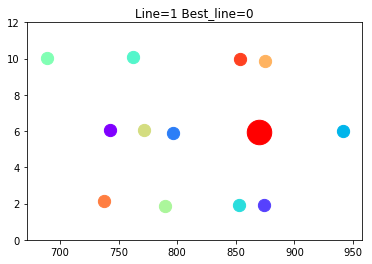

In [15]:
%matplotlib inline 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm 




tmp=data1[995]
prev_x, prev_y, end_path_s, end_path_d, car_speed, ref_yaw, other_cars=get_variables(tmp)
axes = plt.gca()
axes.set_ylim([0,4*3])

line=round((tmp['d']-2)/4)
best_line=get_best_line(other_cars, line, end_path_s, car_speed)

plt.title('Line=%d Best_line=%d' %(line,best_line))

tmp2=[[a[-2],a[-1],sqrt(a[-3]**2+a[-4]**2)] for a in tmp['sensor_fusion'] if a[-1]>=0]

color=cm.rainbow(np.linspace(0,1,len(tmp2)+1))


for i,a in enumerate(tmp2):
    plt.scatter([a[0]],[a[1]],s=150, color=color[i])
    
plt.scatter([tmp['s']],[tmp['d']],color=color[len(tmp2)],s=600)
plt.show()

In [4]:
from ptg import JMT
from helpers import Vehicle
from constants import MAX_JERK, MAX_ACCEL


def efficiency_cost(traj, target_vehicle, delta, T, predictions):
    """
    Rewards high average speeds.
    """
    s, _, t = traj
    s = to_equation(s)
    avg_v = float(s(t)) / t
    return logistic(avg_v)

def nearest_approach_to_any_vehicle(traj, vehicles):
    """
    Calculates the closest distance to any vehicle during a trajectory.
    """
    closest = 999999
    for vid, v in vehicles.items():
        d = nearest_approach(traj,v)
        if d < closest:
            closest = d
    return closest

def nearest_approach(traj, vehicle):
    closest = 999999
    s_,d_,T = traj
    s = to_equation(s_)
    d = to_equation(d_)
    for i in range(100):
        t = float(i) / 100 * T
        cur_s = s(t)
        cur_d = d(t)
        targ_s, _, _, targ_d, _, _ = vehicle.state_in(t)
        dist = sqrt((cur_s-targ_s)**2 + (cur_d-targ_d)**2)
        if dist < closest:
            closest = dist
    return closest


def buffer_cost(traj, target_vehicle, delta, T, predictions):
    """
    Penalizes getting close to other vehicles.
    """
    
    nearest = nearest_approach_to_any_vehicle(traj, predictions)
    
    #print ('nearst:', nearest)
    return logistic(2*VEHICLE_RADIUS / nearest)




WEIGHTED_COST_FUNCTIONS = [
    #(time_diff_cost,    1),
    #(s_diff_cost,       1),
    #(d_diff_cost,       1),
    (efficiency_cost,   1),
    (max_jerk_cost,     0),
    (total_jerk_cost,   0),
    (collision_cost,    1),
    (buffer_cost,       0),
    (max_accel_cost,    0),
    (total_accel_cost,  0),
]




def PTG(predictions, target_vehicle,  delta_d, max_acc=100.0, rt=[float(a)/10 for a in range(15,25)]):
    # generate alternative goals
    all_goals = []
    start_s = target_vehicle.state_in(0)[:3]
    start_d = target_vehicle.state_in(0)[3:]
    
    
    for t in rt:
        for acc in [0]:#[-max_acc/2,-max_acc/4,0,max_acc/2,max_acc/4]:
            target=target_vehicle.state_in(t)
            target[0]+=acc*t
            target[3]+=delta_d
            all_goals.append((target[:3],target[3:],t))
            
    # find best trajectory
    trajectories = []
    for goal in all_goals:
        s_goal, d_goal, t = goal
        s_coefficients = JMT(start_s, s_goal, t)
        d_coefficients = JMT(start_d, d_goal, t)
        trajectories.append(tuple([s_coefficients, d_coefficients, t]))
    
    costs=[calculate_cost(tr, None, None, tr[-1], predictions, WEIGHTED_COST_FUNCTIONS) for tr in trajectories]
    
    print ('costs:', costs,'\n\n')
    
    best = min(trajectories, key=lambda tr: \
               calculate_cost(tr, None, None, tr[-1], predictions, WEIGHTED_COST_FUNCTIONS))
    print ('best=',best)
    cost = calculate_cost(best, target_vehicle, delta, T, predictions, WEIGHTED_COST_FUNCTIONS, verbose=True)
    return trajectories[0],trajectories[-1]

NameError: name 'max_jerk_cost' is not defined

In [162]:
tmp2[1][0]=end_path_s

In [169]:
vehicle = Vehicle([end_path_s,car_speed,0,end_path_d, 0,0])

predictions = {}
#add all other vehicles
for i in range(len(tmp2)):
    predictions[i+1]=Vehicle([tmp2[i][0],tmp2[i][2],0,tmp2[i][1], 0,0,0])

target = best_line*4+2
delta = [0, 0, 0, 0, 0 ,0]
start_s = [end_path_s, car_speed, 0]
start_d = [end_path_d, 0, 0]
T = 2.5

res=PTG(predictions, vehicle, best_line*4+2-end_path_d)

print (res[-1])

costs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 


best= (array([ 889.4632    ,   20.96902477,    0.        ,    0.        ,
         -0.        ,    0.        ]), array([  5.884211  ,   0.        ,   0.        , -11.50877333,
        11.50877333,  -3.06900622]), 1.5)
(array([ 889.4632    ,   20.96902477,    0.        ,    0.        ,
          0.        ,    0.        ]), array([ 5.884211  ,  0.        ,  0.        , -2.80975911,  1.75609945,
       -0.29268324]), 2.4)


In [144]:
res

((array([ 889.4632    ,   20.96902477,    0.        , -222.22222222,
          222.22222222,  -59.25925926]),
  array([  5.884211  ,   0.        ,   0.        , -11.50877333,
          11.50877333,  -3.06900622]),
  1.5),
 1.0)

1.5


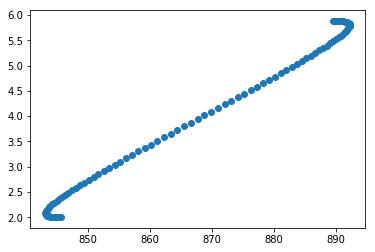

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt

cnt_points=100
points=np.zeros((cnt_points,2), dtype=np.float)

q=res[0]
T=res[0][2]

print (T)

for i in range(cnt_points):
    t=T*float(i)/cnt_points
    
    s=sum([q[0][j]*t**j for j in range(6)])
    d=sum([q[1][j]*t**j for j in range(6)])
    points[i]=[s,d]
    
plt.scatter(points[:,0],points[:,1])
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
1.5


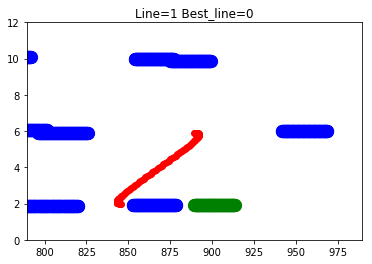

In [137]:
%matplotlib inline 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm 


q=res[0]
T=res[0][2]



tmp=data1[995]
prev_x, prev_y, end_path_s, end_path_d, car_speed, ref_yaw, other_cars=get_variables(tmp)
axes = plt.gca()
axes.set_ylim([0,4*3])
axes.set_xlim([end_path_s-100,end_path_s+100])

line=round((tmp['d']-2)/4)
best_line=get_best_line(other_cars, line, end_path_s, car_speed)

plt.title('Line=%d Best_line=%d' %(line,best_line))

tmp2=[[a[-2],a[-1],sqrt(a[-3]**2+a[-4]**2)] for a in tmp['sensor_fusion'] if a[-1]>=0]

color=cm.rainbow(np.linspace(0,1,len(tmp2)+1))


for vid, vehicle in predictions.items():
    points=np.zeros((cnt_points,2), dtype=np.float)


    for i in range(cnt_points):
        t=T*float(i)/cnt_points 
        s=vehicle.state_in(t)[0]
        d=vehicle.state_in(t)[3]
        
        points[i]=[s,d]
    color='blue'
    print (vid)
    if vid==2:
        color='green'
    plt.scatter(points[:,0],points[:,1],s=150, color=color)
    
points=np.zeros((cnt_points,2), dtype=np.float)

q=res[0]
T=res[0][2]

print (T)

for i in range(cnt_points):
    t=T*float(i)/cnt_points
    
    s=sum([q[0][j]*t**j for j in range(6)])
    d=sum([q[1][j]*t**j for j in range(6)])
    points[i]=[s,d]
    
plt.scatter(points[:,0],points[:,1],color='red')
plt.show()    
    
plt.show()

In [12]:
z=Vehicle([end_path_s,car_speed,0,end_path_d, 0,0])

In [13]:
z.state_in(0)

[889.4632, 20.969024774646886, 0, 5.884211, 0, 0]

In [14]:
end_path_s

889.4632

In [115]:
s1,d1=predictions[2].state_in(T)[0],predictions[2].state_in(T)[3]

In [116]:
s=sum([q[0][j]*T**j for j in range(6)])
d=sum([q[1][j]*T**j for j in range(6)])
    

In [117]:
s,d, s1, d1

(914.16673716197033, 1.9999999999999929, 913.7537139178997, 1.896934)

In [118]:
sqrt((s1-s)**2+(d1-d)**2)

0.4256886191790779

In [192]:
def total_accel_cost(traj):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    a = to_equation(s_d_dot)
    total_acc = 0
    dt = float(T) / 100.0
    for i in range(100):
        t = dt * i
        acc = a(t)
        total_acc += abs(acc*dt)
    acc_per_second = total_acc / T
    
    return logistic(acc_per_second / EXPECTED_ACC_IN_ONE_SEC )
    
def max_accel_cost(traj):
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    a = to_equation(s_d_dot)
    all_accs = [a(float(T)/100 * i) for i in range(100)]
    max_acc = max(all_accs, key=abs)
    if abs(max_acc) > MAX_ACCEL: return 1
    else: return 0
    

def max_jerk_cost(traj):
    s, d, t = traj
    T=t
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    jerk = differentiate(s_d_dot)
    jerk = to_equation(jerk)
    all_jerks = [jerk(float(T)/100 * i) for i in range(100)]
    max_jerk = max(all_jerks, key=abs)
    if abs(max_jerk) > MAX_JERK: return 1
    else: return 0

def total_jerk_cost(traj):
    s, d, t = traj
    T=t
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    jerk = to_equation(differentiate(s_d_dot))
    print (s, s_dot, s_d_dot)
    total_jerk = 0
    dt = float(T) / 100.0
    for i in range(100):
        t = dt * i
        j = jerk(t)
        total_jerk += abs(j*dt)
    jerk_per_second = total_jerk / T
    return logistic(jerk_per_second / EXPECTED_JERK_IN_ONE_SEC )

In [176]:
res[0]

(array([ 889.4632    ,   20.96902477,    0.        ,    0.        ,
          -0.        ,    0.        ]),
 array([  5.884211  ,   0.        ,   0.        , -11.50877333,
         11.50877333,  -3.06900622]),
 1.5)

In [177]:
res[1]

(array([ 889.4632    ,   20.96902477,    0.        ,    0.        ,
           0.        ,    0.        ]),
 array([ 5.884211  ,  0.        ,  0.        , -2.80975911,  1.75609945,
        -0.29268324]),
 2.4)

In [193]:
total_jerk_cost(res[0]), total_jerk_cost(res[1])

[ 889.4632       20.96902477    0.            0.           -0.            0.        ] [20.969024774646886, 0.0, 0.0, -0.0, 0.0] [0.0, 0.0, -0.0, 0.0]
[ 889.4632       20.96902477    0.            0.            0.            0.        ] [20.969024774646886, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


(0.0, 0.0)

In [194]:
res[0]

(array([ 889.4632    ,   20.96902477,    0.        ,    0.        ,
          -0.        ,    0.        ]),
 array([  5.884211  ,   0.        ,   0.        , -11.50877333,
         11.50877333,  -3.06900622]),
 1.5)